<a href="https://colab.research.google.com/github/R-Jin/bird-song-classifier/blob/main/bird_song_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset location

In [2]:
from google.colab import drive

# Mount Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive')

# Setup target directory
target_dir = "/content/drive/MyDrive/birdclef-2025"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Imports

In [3]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import librosa.display
import re
import numpy as np

# Constants

In [4]:
BATCH_SIZE = 64

SAMPLE_RATE = 32000
HOP_LENGTH = 512

# Some unwanted song type labels... may use later (Filter out unwanted labels, e.g. "frog", and combine labels with similar names)


In [5]:
unwanted_labels = [
    'uncertain', 'frog', 'frogs', 'car', 'plane', 'wind', 'river', 'surf',
    'motor', 'insect', 'noise', 'background', 'voices', 'human', 'dog',
    'perro', 'cow', 'latido', 'engine', 'traffic', 'urban', 'música',
    'music', 'unknown', 'no idea', '?', 'nao', 'não', 'environmental',
    'ambient', 'dogs', 'bird in h', 'laughing', 'hits', 'chatter', 'mechanical', 'imitation',
    'river in background', 'human voices', 'car noises', 'frogs and insects'
]

canonical_labels = {
    'song': ['song', 'songs', 'full song', 'complete song', 'alternate song', 'display song', 'morning song', 'evening song', 'day song', 'dawn song', 'vesper song', 'nuptial song', 'predawn song'],
    'call': ['call', 'calls', 'typical call', 'short call', 'long call', 'flight call', 'begging call', 'alarm call', 'chase call', 'contact call', 'feeding call', 'distress call', 'display call', 'excited call', 'juvenile call'],
    'alarm call': ['alarm call', 'alarm calls', 'alarm', 'alarm whistle', 'alarm call?', 'alarm call in flight'],
    'flight call': ['flight call', 'calls in flight', 'call in flight', 'flight calls', 'take-off calls', 'take-off call'],
    'duet': ['duet', 'duet song', 'duet call', 'couple duet', 'song and duet', 'duetting'],
    'drum': ['drum', 'drumming', 'bill snap', 'bill snapping', 'wing beat', 'wing flaps', 'wing noise', 'wing flutter', 'wing flutters', 'wing sounds', 'wing whirr', 'wing whirrs', 'wing snaps', 'bill/wing snapping'],
    'subsong': ['subsong', 'subsong?', '"subsong"'],
    'trill': ['trill', 'trilled call', 'trill call', 'cooing trill'],
    'display': ['display', 'display song', 'display call', 'song during display flight', 'display song & instrumental wings noise'],
}


# Read and clean data

In [6]:
# Only necessary for cleaning
#unwanted_labels = ['aberrant', 'perched', 'bill snaps', 'rattle', 'scold', 'snap', 'chatter', 'mechanical sounds', 'wind', 'lekking', 'lek', 'grunts', 'tapping', 'mechanical', 'voces humanas', 'immature', 'roll-snap', 'bill/wing snapping', 'estridulación', 'frogs', 'bill rattle']

label_map = {
    'song' : 'song',
    '' : 'unknown', #?????
    'call' : 'call',
    'flight call' : 'flight call',
    'alarm call' : 'alarm call',
    'duet' : 'duet',
    'calls' : 'call',
    'dawn song' : 'song', # ?
    'uncertain' : 'unknown', #?????
    'begging call' : 'begging call',
    'drumming' : 'drumming',
    'subsong' : 'subsong',
    'canto' : 'song',
    'flight calls' : 'flight call',
    'nocturnal flight call' : 'flight call', # ?
    # aberrant?
    'chamado' : 'call',
    'advertisement call' : 'call', # call?
    'hatchling or nestling' : 'hatchling or nestling',
    'interaction calls' : 'call', # call?
    'songs' : 'song',
    '?' : 'unknown',
    'song?' : 'song',
    'chorus' : 'song', # ?
    'alarm calls' : 'alarm call',
    'wing sound' : 'wing sound',
    'long song' : 'song',
    'imitation' : 'imitation',
    'wing sounds' : 'wing sound',
    'wing beats' : 'wing sound',
    'wing noise' : 'wing sound',
    # lekking?
    'display song' : 'song', # ?
    # perched?
    'excited calls' : 'call', #?
    # bill snaps?
    'morning song' : 'song', # ?
    'chase calls' : 'call', # ?
    'wing whirrs' : 'wing sound',
    # rattle?
    'alarm' : 'alarm call',
    'drum' : 'drumming',
    'wing snaps' : 'wing sound',
    'dueto' : 'duet',
    'short song' : 'song',
    # scold?
    'call?' : 'call',
    'song in flight' : 'song', # ?
    'song in duet' : 'duet',
    # snap?
    'mimicry/imitation' : 'imitation',
    'flight song': 'song', # ?
    'agitated calls' : 'call', # ?
    'interaction call' : 'call',
    'alternate song' : 'song',
    'take-off and flight calls' : 'flight call',
    'calls at roost' : 'call', # ?
    # lek ?
    'half song' : 'song',
    'couple song' : 'duet', #????
    # chatter?
    'short call' : 'call',
    'typical call' : 'call',
    # mechanical sounds?
    'mimicking' : 'imitation',
    'wing beat' : 'wing sound',
    'bater de asas' : 'wing sound',
    'song a' : 'song',
    'agitated song' : 'song', #????
    'duet song' : 'duet',
    'batido de asas' : 'wing sound',
    'wing flutter' : 'wing sound',
    # wind??
    'immature calls' : 'call',
    'daytime song' : 'song', # ?
    '"call' : 'call',
    'excited song' : 'song', # ?
    'song 2' : 'song',
    'wing flaps' : 'wing sound',
    'aggressive call' : 'call',
    'territorial call' : 'call',
    'feeding call' : 'call',
    'take-off calls' : 'flight call', # ?????
    'contact calls' : 'call',
    'song during display flight' : 'song',
    'calls on perch' : 'call',
    'perched call' : 'call',
    # grunts ?
    'daytime calls' : 'call',
    'daytime call' : 'call',
    'dawn duet' : 'duet',
    'take-off call' : 'flight call', # ?????
    'calls (2 types)' : 'call',
    'perched calls' : 'call',
    # tapping ?
    # mechanical ?
    # voces humanas ?
    'agitated call' : 'call',
    'single song' : 'song',
    'distress call of a bird being handled.' : 'call',
    'nuptial song' : 'song',
    'begging calls' : 'begging call',
    # immature ?
    'vesper song' : 'song',
    'song (variation)' : 'song',
    # roll-snap ?
    'call in flight' : 'call',
    'chase call' : 'call',
    'canto de voo' : 'song',
    # estridulación ?
    # frogs ?
    # bill rattle ?
    'couple duet' : 'duet',
    'rattle calls' : 'call',

    # song while displaying.....
 }

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/birdclef-2025/train.csv")

def clean_label(label):
  results = re.findall(r"'([^']*)'", label)
  for result in results:
    result = result.lower()

    if pd.isna(label):
        return None
    label = str(label).lower().strip()
    return label_map.get(label, None)

def clean_labels(df): # Pass df as an argument
  cleaned = []
  for song_types in df['type']: # Iterate over df['type']
    results = re.findall(r"'([^']*)'", song_types)
    labels = []
    for result in results:
      # Convert to lowercase for consistency
      result = result.lower()
      #result = label_map.get(result, result)
      result = label_map.get(result, None)

      if result is not None:
        if result not in labels:
          labels.append(result)

    if len(labels) == 0:
      labels = ['unknown']

    cleaned.append(labels)
  return cleaned # Return the cleaned list

train_df['type'] = clean_labels(train_df)

# Read dataset

In [8]:
unique_song_types = set()
unique_bird_species = set()

for bird_species in train_df['primary_label']:
  unique_bird_species.add(bird_species)

for song_types in train_df['type']:
  for song_type in song_types:
    unique_song_types.add(song_type)


print(f"Number of unique bird species: {len(unique_bird_species)}" )
print(f"Number of unique song types: {len(unique_song_types)}")
print(unique_song_types)


Number of unique bird species: 206
Number of unique song types: 12
{'imitation', 'alarm call', 'song', 'unknown', 'begging call', 'subsong', 'duet', 'drumming', 'wing sound', 'flight call', 'hatchling or nestling', 'call'}


In [9]:
# Maps of song types and bird species to labels
song_type_to_label = {song_type: i for i, song_type in enumerate(unique_song_types)}
bird_species_to_label = {bird_species: i for i, bird_species in enumerate(unique_bird_species)}

In [10]:
# Collate function

def collate_fn(batch):
    waveforms, species_labels, type_labels = zip(*batch)  # unzip the batch tuples

    # Filter out any empty waveforms (in case of loading errors)
    batch_cleaned = [
        (wf, sl, tl) for wf, sl, tl in zip(waveforms, species_labels, type_labels)
        if wf.numel() > 0
    ]
    if len(batch_cleaned) == 0:
        raise ValueError("All items in batch are invalid!")

    waveforms, species_labels, type_labels = zip(*batch_cleaned)

    # Pad all waveforms to the length of the longest one in the batch
    max_len = max([wf.shape[-1] for wf in waveforms])
    padded_waveforms = []
    for wf in waveforms:
        pad_size = max_len - wf.shape[-1]
        padded_wf = F.pad(wf, (0, pad_size))  # Pad only the time axis (last dim)
        padded_waveforms.append(padded_wf)

    # Stack everything into tensors
    waveforms_tensor = torch.stack(padded_waveforms)
    species_labels_tensor = torch.stack(species_labels)
    type_labels_tensor = torch.stack(type_labels)

    return waveforms_tensor, species_labels_tensor, type_labels_tensor  # Return all three tensors

In [14]:
# Generated with gemini
# Prompt: Create data loaders

split_in_seconds = 15
max_width = split_in_seconds * SAMPLE_RATE // HOP_LENGTH

class BirdClefDataset(Dataset):
    def __init__(self, df, target_dir, audio_transform=None, max_width=max_width):
        self.df = df
        self.target_dir = target_dir
        self.audio_transform = audio_transform
        self.max_width = max_width

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.target_dir, "train_audio", row["filename"])

        try:
            waveform, sample_rate = torchaudio.load(audio_path)
        except Exception as e:
            print(f"Error loading file {audio_path}: {e}")
            waveform = torch.zeros(1, self.max_width)
            species_label = torch.tensor(0, dtype=torch.long)  # Default class
            type_label = torch.zeros(len(unique_song_types), dtype=torch.float32)
            return waveform, species_label, type_label

        if self.audio_transform:
            mel = self.audio_transform(waveform)  # [1, n_mels, time]
        else:
            mel = waveform  # fallback if no transform

        # Crop or pad mel to fixed width
        if mel.shape[-1] > self.max_width:
            mel = mel[:, :, :self.max_width]
        elif mel.shape[-1] < self.max_width:
            pad_amt = self.max_width - mel.shape[-1]
            mel = F.pad(mel, (0, pad_amt))  # pad last dimension (time)

        # Labels
        species_label = bird_species_to_label[row['primary_label']]
        species_label = torch.tensor(species_label, dtype=torch.long)

        type_label = torch.zeros(len(unique_song_types), dtype=torch.float32)
        for song_type in row['type']:
            if song_type in song_type_to_label:
                type_label[song_type_to_label[song_type]] = 1

        return mel, species_label, type_label

train_dataset = BirdClefDataset(train_df, target_dir, torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, hop_length=HOP_LENGTH), max_width)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


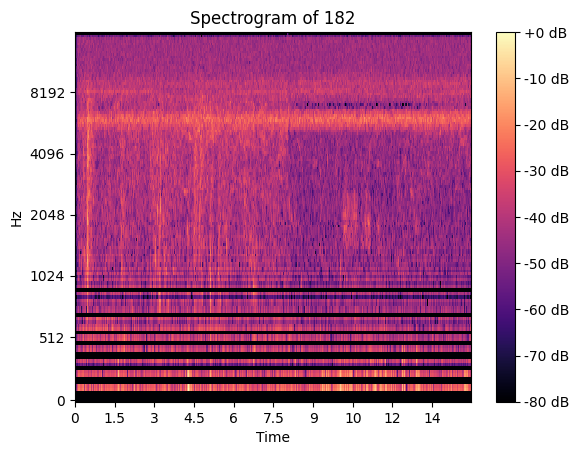

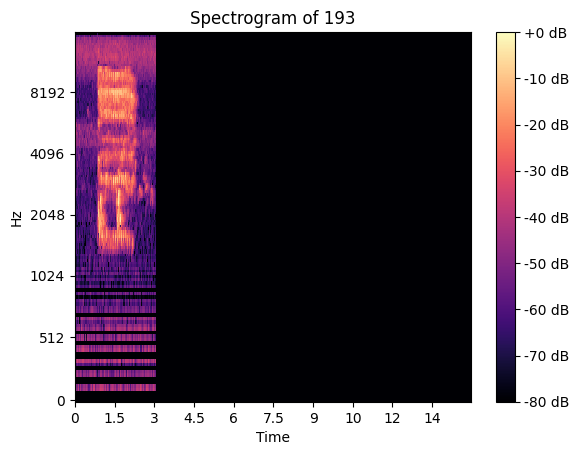

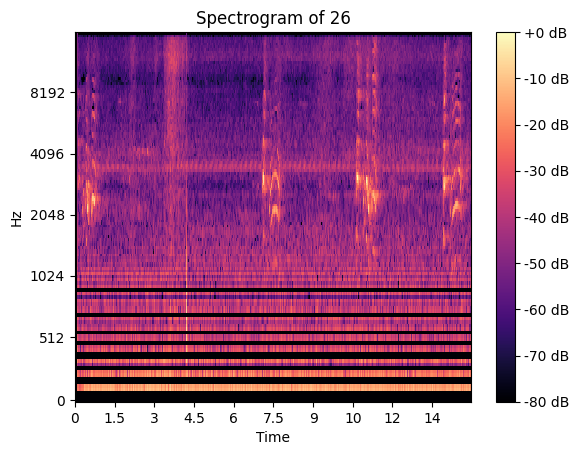

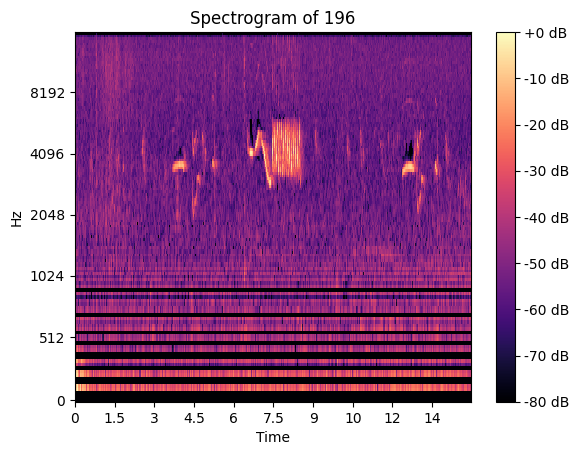

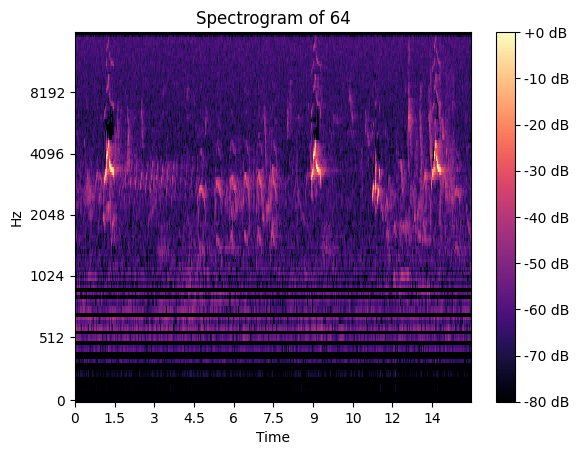

In [15]:
 # Generated with GPT
# prompt: Visualise the data set

import matplotlib.pyplot as plt
import librosa.display

def visualize_spectrograms(train_loader, num_spectrograms=5):
    count = 0
    for waveforms, species_labels, type_labels in train_loader:
        for j in range(waveforms.shape[0]):
            if count >= num_spectrograms:
                return  # done

            spectrogram = waveforms[j, 0, :, :].cpu().numpy()

            fig, ax = plt.subplots()
            img = librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                                           x_axis='time', y_axis='mel', sr=SAMPLE_RATE, ax=ax)
            ax.set(title=f'Spectrogram of {species_labels[j]}') # Use species_labels for the title
            fig.colorbar(img, ax=ax, format="%+2.f dB")
            plt.show()
            count += 1

visualize_spectrograms(train_loader)

# Neural network


In [16]:
class BirdSongClassifier(nn.Module):
    def __init__(self, num_species, num_song_types):
      super(BirdSongClassifier, self).__init__()
      self.num_species = num_species
      self.num_song_types = num_song_types

      # Shared CNN Backbone
      self.backbone = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(16, 32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1))
      )

      # Shared features fully connected layer
      self.shared_fc = nn.Linear(128, 128)

      # Bird species classification
      self.species_head = nn.Linear(128, self.num_species)

      # Song types classification (Multi-label)
      self.type_head = nn.Linear(128, self.num_song_types)

    def forward(self, x):
      x = self.backbone(x)
      x = x.view(x.size(0), -1)
      x = self.shared_fc(x)
      x = F.relu(x)

      species_out = self.species_head(x)
      type_out = self.type_head(x)

      return species_out, type_out

# Training

In [17]:
def train_epoch(model, train_loader, criterion_species, criterion_type, optimizer, device):
  model.train()
  loss = 0
  i = 0

  for inputs, species_labels, types_labels in train_loader:
    inputs, species_labels, types_labels = inputs.to(device), species_labels.to(device), types_labels.to(device)

    optimizer.zero_grad()
    species_outputs, types_outputs = model(inputs)

    species_loss = criterion_species(species_outputs, species_labels)
    types_loss = criterion_type(types_outputs, types_labels)

    total_loss = species_loss + types_loss
    total_loss.backward()
    optimizer.step()

    loss += total_loss.item()
    i += 1
    print(f"Batch {i}/{len(train_loader)} - Loss: {total_loss.item()}")

  return loss / len(train_loader)

In [18]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = BirdSongClassifier(len(unique_bird_species), len(unique_song_types))
model.to(device)

# Loss
criterion_species = nn.CrossEntropyLoss()       # For bird species (multi-class)
criterion_type = nn.BCEWithLogitsLoss()      # For song types (multi-label)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_epochs = 10

for epoch in range(num_epochs):
  train_loss = train_epoch(model, train_loader, criterion_species, criterion_type, optimizer, device)

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}")

# mel transform with pytorch (GPU)
# Resample audio files with lower frequency
# Increase hop length
# Increase number of workers

# Precompute mel spectrograms
# Increase length back to 60 seconds again?

Batch 1/447 - Loss: 5.993989944458008
Batch 2/447 - Loss: 5.995879173278809
Batch 3/447 - Loss: 5.996885299682617
Batch 4/447 - Loss: 5.981719493865967
Batch 5/447 - Loss: 5.965737819671631
Batch 6/447 - Loss: 5.959108352661133
Batch 7/447 - Loss: 5.950937271118164
Batch 8/447 - Loss: 5.929412841796875
Batch 9/447 - Loss: 5.923523902893066
Batch 10/447 - Loss: 5.895362854003906
Batch 11/447 - Loss: 5.923703670501709
Batch 12/447 - Loss: 5.849777698516846
Batch 13/447 - Loss: 5.874446392059326
Batch 14/447 - Loss: 5.882979393005371
Batch 15/447 - Loss: 5.855240821838379
Batch 16/447 - Loss: 5.819640636444092
Batch 17/447 - Loss: 5.807823181152344
Batch 18/447 - Loss: 5.790875434875488
Batch 19/447 - Loss: 5.790219306945801
Batch 20/447 - Loss: 5.736611366271973
Batch 21/447 - Loss: 5.736710071563721
Batch 22/447 - Loss: 5.7688493728637695
Batch 23/447 - Loss: 5.722769737243652
Batch 24/447 - Loss: 5.6775431632995605
Batch 25/447 - Loss: 5.587899684906006
Batch 26/447 - Loss: 5.755715370

KeyboardInterrupt: 